# Обучение CNN классификатора

In [168]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

%matplotlib inline 

In [169]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [171]:
train_losses = []
train_accuracies = []
val_losess = []
val_accuracies = []

In [174]:
model = models.resnet34(pretrained=True)
num_classes = 5

model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

# model.load_state_dict(torch.load('best_model.pth'))

/Users/anton/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/anton/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [175]:
# Пути к данным
train_data_dir = "data/train/"
val_data_dir = "data/validation/"

IMG_SIZE = 224
# Трансформации

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(90),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

batch_size=64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [176]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1 

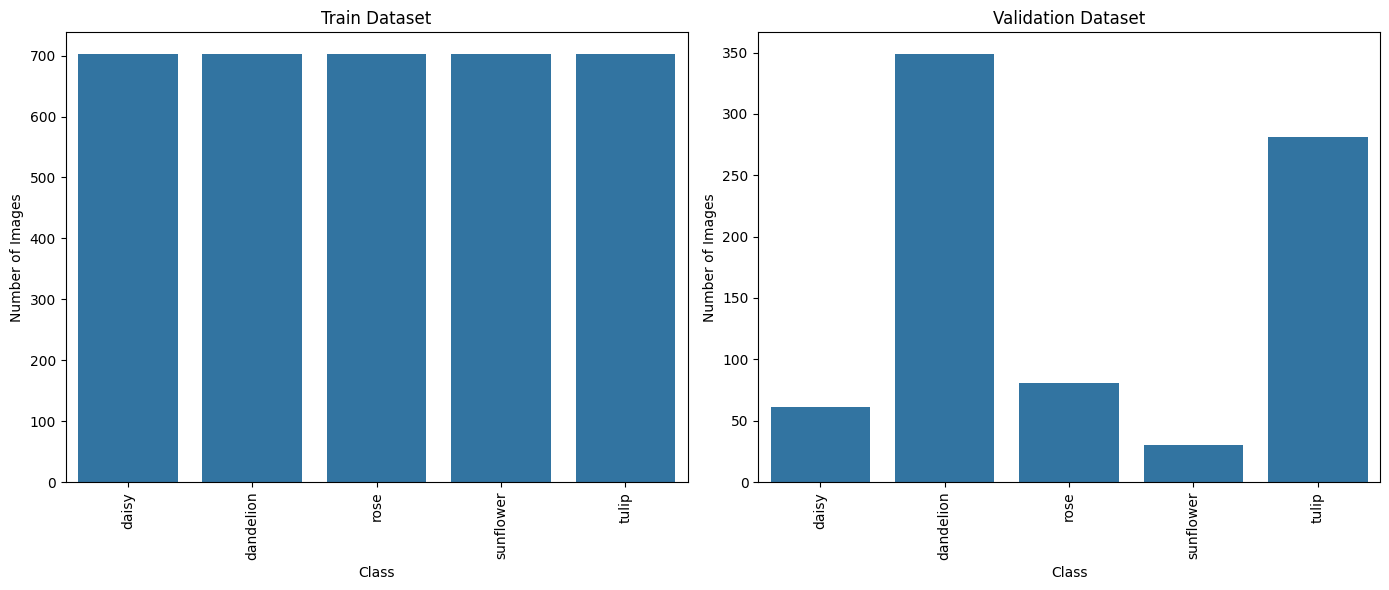

In [179]:
# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Images without normalization:


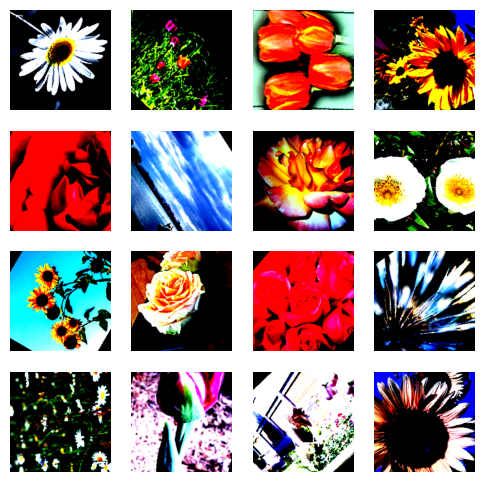

In [180]:
# Функция для отображения изображений из батча
def show_images(images, denormalize=False):
    if denormalize:
        # Обратное преобразование для нормализации
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images, _ = next(iter(train_dataloader))

# Отображение изображений с восстановлением цветов
print("Images without normalization:")
show_images(images, denormalize=False)

In [181]:
len(val_dataloader), len(train_dataloader)

(13, 55)

In [91]:
import os.path
# Загрузка cохраненной модели
jit_model_file_path = 'best_model.ptc'
model_file_path = 'best_model.pth'
if os.path.exists(jit_model_file_path):
    model = torch.jit.load(jit_model_file_path)
    print("Load allmost model")
elif os.path.exists(model_file_path):
    model.load_state_dict(torch.load(model_file_path))
    print("Load only state_dict")

Load allmost model


In [193]:
# Валидация модели до обучения:
model.eval()
model.to(device)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        value, max_indexes = torch.max(outputs, 1)
        total += labels.size(0)
        correct += max_indexes.eq(labels).sum().item()
val_accuracy = correct/total

val_accuracy

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:31<00:00,  2.43s/it]


0.8865336658354115

In [90]:
def move_img_from_train():      
    classes = ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']
    import shutil

    for name in classes:
        count = 0
        print(name)
        sourse = f"data/train/{name}/"
        for file in os.listdir(sourse):
            if count > 703:
                print(count)
                print("move: ", file)
                shutil.move(os.path.join(sourse, file), f"data/validation/{name}/")
            count += 1

        print(count)

In [192]:
torch.save(model.state_dict(), model_file_path)
trace_image = torch.randn(batch_size, 3, IMG_SIZE, IMG_SIZE)
traced_model = torch.jit.trace(model, trace_image.to(device))
torch.jit.save(traced_model, jit_model_file_path)
print("Save best model")

Save best model


In [194]:
# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimaizer = optim.Adam(model.parameters(), lr=0.0005)

# число эпох
num_epochs = 8

best_val_accuracy = 0

model.to(device)
for epoch in range(num_epochs):
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimaizer.zero_grad()

        outputs = model(images)
        losess = criterion(outputs, labels)
        losess.backward()
        optimaizer.step()
    
        running_loss += losess.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss/len(train_dataloader)
    train_losses.append(train_loss)
    train_accuracy = correct/total
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_dataloader)
    val_losess.append(val_loss)
    val_accuracy = correct/total
    val_accuracies.append(val_accuracy)  

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}') 

    # Сохранение лучшей модели на основе валидационной точности
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_file_path)
        trace_image = torch.randn(batch_size, 3, IMG_SIZE, IMG_SIZE)
        traced_model = torch.jit.trace(model, trace_image.to(device))
        torch.jit.save(traced_model, jit_model_file_path)
        print("Save best model")

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), "last_model.pth")



100%|██████████| 13/13 [00:34<00:00,  2.68s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718]
Epoch [1/8], Train Loss: 0.3578, Train Accuracy: 0.8740, Val Loss: 0.3647, Val Accuracy: 0.8766
Save best model


100%|██████████| 13/13 [00:34<00:00,  2.65s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624]
Epoch [2/8], Train Loss: 0.2882, Train Accuracy: 0.8993, Val Loss: 0.4237, Val Accuracy: 0.8616


100%|██████████| 13/13 [00:35<00:00,  2.76s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291]
Epoch [3/8], Train Loss: 0.2521, Train Accuracy: 0.9067, Val Loss: 0.6371, Val Accuracy: 0.8092


100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845, 0.42030763855347264]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291, 0.8603491271820449]
Epoch [4/8], Train Loss: 0.2577, Train Accuracy: 0.9115, Val Loss: 0.4203, Val Accuracy: 0.8603


100%|██████████| 13/13 [00:32<00:00,  2.53s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845, 0.42030763855347264, 0.3935440881894185]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291, 0.8603491271820449, 0.8665835411471322]
Epoch [5/8], Train Loss: 0.2410, Train Accuracy: 0.9172, Val Loss: 0.3935, Val Accuracy: 0.8666


100%|██████████| 13/13 [00:40<00:00,  3.11s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845, 0.42030763855347264, 0.3935440881894185, 0.6438943010110122]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291, 0.8603491271820449, 0.8665835411471322, 0.7855361596009975]
Epoch [6/8], Train Loss: 0.1976, Train Accuracy: 0.9334, Val Loss: 0.6439, Val Accuracy: 0.7855


100%|██████████| 13/13 [41:59<00:00, 193.81s/it] 


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845, 0.42030763855347264, 0.3935440881894185, 0.6438943010110122, 0.4094970100201093]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291, 0.8603491271820449, 0.8665835411471322, 0.7855361596009975, 0.885286783042394]
Epoch [7/8], Train Loss: 0.1844, Train Accuracy: 0.9323, Val Loss: 0.4095, Val Accuracy: 0.8853
Save best model


100%|██████████| 13/13 [00:36<00:00,  2.82s/it]


val_losess [0.5106776964205962, 0.4661311048727769, 0.3556038657060036, 0.3647308578858009, 0.42367981718136716, 0.63709612763845, 0.42030763855347264, 0.3935440881894185, 0.6438943010110122, 0.4094970100201093, 0.5201868529503162]
val_accuracies [0.8366583541147132, 0.8341645885286783, 0.8865336658354115, 0.8765586034912718, 0.8615960099750624, 0.8092269326683291, 0.8603491271820449, 0.8665835411471322, 0.7855361596009975, 0.885286783042394, 0.8566084788029925]
Epoch [8/8], Train Loss: 0.1782, Train Accuracy: 0.9385, Val Loss: 0.5202, Val Accuracy: 0.8566


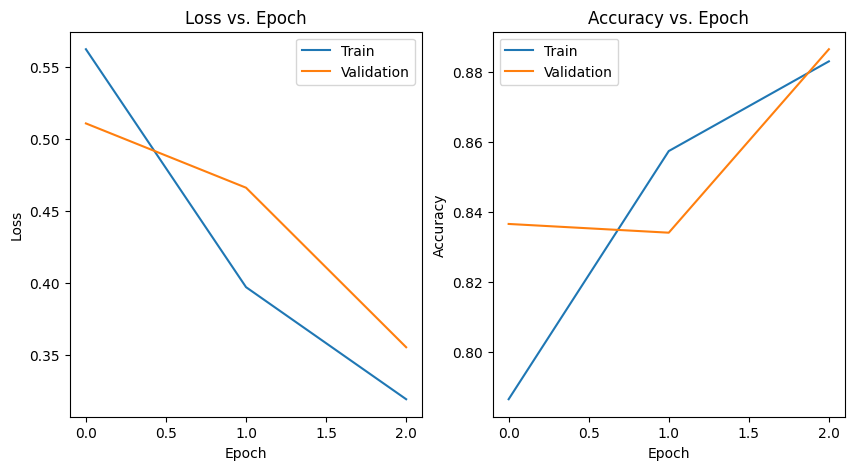

In [184]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(val_losess)), val_losess, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [185]:
# Получение метрик качества для текущих весов модели
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Функция для построения графика матрицы ошибок
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        61
           1       1.00      0.87      0.93       349
           2       0.80      0.96      0.87        81
           3       0.31      1.00      0.48        30
           4       0.99      0.81      0.89       281

    accuracy                           0.86       802
   macro avg       0.76      0.90      0.79       802
weighted avg       0.92      0.86      0.88       802

Test Accuracy: 0.8603


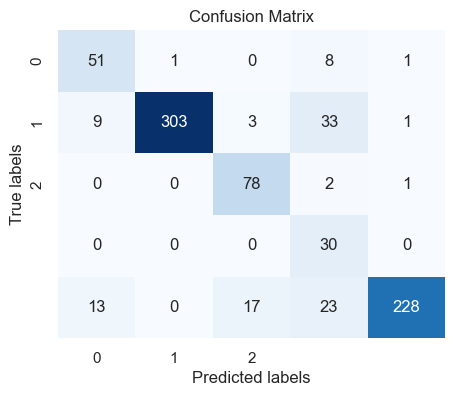

In [103]:
# Загрузка весов модели
# model.load_state_dict(torch.load('best_model.pth'))
model = torch.jit.load(jit_model_file_path)
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_dataloader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

# Инференс готовой модели

In [186]:
# Загрузка весов модели
# model = torch.jit.load(jit_model_file_path)
model.to(device)
model.eval()

# Предобработка изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

tensor([[ 1.2285, -0.2743, -1.6228, -0.1550, -0.7585]])


Text(0.5, 1.0, 'Predicted: tulip (99.80%)')

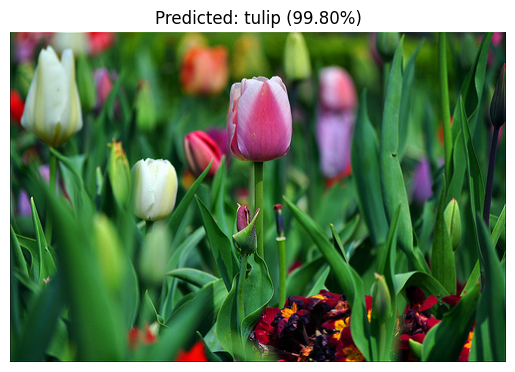

In [191]:
# Загрузите изображение для инференса
image_path = 'data/validation/tulip/8686332852_c6dcb2e86b.jpg'
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device) # Добавляем размер батча
image_tensor.shape

# Прогон изображения через модель
with torch.no_grad():
    print(outputs)
    outputs = model(image_tensor)

# Примените softmax для получения вероятностей классов
probabilities = torch.nn.functional.softmax(outputs[0], dim=0).cpu()
top_prob, top_index = torch.topk(probabilities, 1)

predict_class = val_dataset.classes[top_index]
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {predict_class} ({top_prob.item()*100:.2f}%)")
# tensor([[-3.8982, -3.4177, -2.7547, -1.7675, -3.5466]])

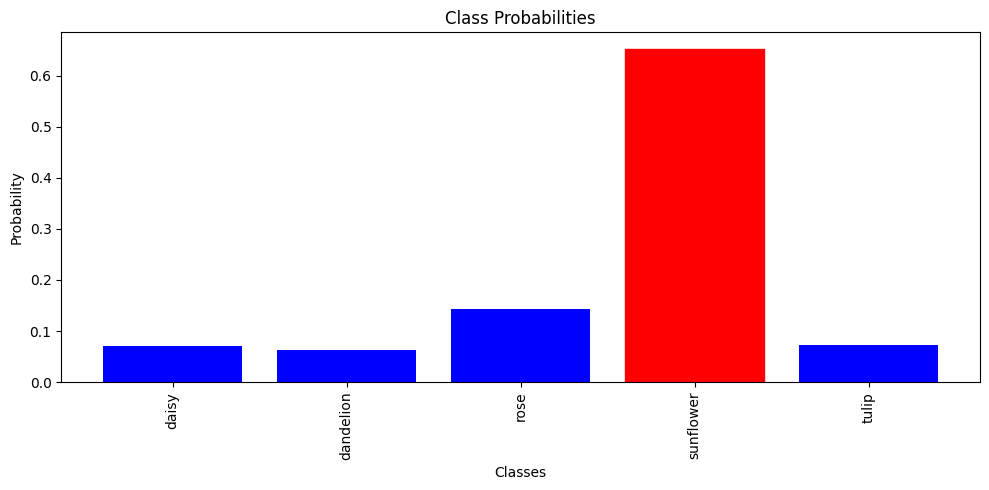

In [159]:
# Построить барплот
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(probabilities)), probabilities, color='blue')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.xticks(range(len(probabilities)), val_dataset.classes, rotation='vertical')

# Подсветить класс с наибольшей уверенностью
bars[top_index].set_color('red')

plt.tight_layout()
plt.show()